In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

Class modification:
1.   Constructor now needs a function as a parameter
2.   There is a generic function that is used after each convolution network or fully connected network.

Now we can have many models with different activation functions


In [0]:
class Net(nn.Module):
    def __init__(self, func):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.function = func
    def forward(self, x):
        x = self.function(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.function(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = self.function(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses=[]
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target=data.to(device), target.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss=F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( 
                 epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx/len(train_loader) , loss.item()))
    return losses

In [0]:
def validate(model, device, loader):
    model.eval()  #model in evaluation mode
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    validation_loss /= len(loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset), 100.*correct/len(loader.dataset)))
    return validation_loss

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

Sigmoid, ReLU, Leaky ReLU and Hyperbolic Tanjant differences:

![alt text](https://i.imgur.com/0yIq5yx.png)

Each model now prints the name of its activation function.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ReLU = Net(F.relu).to(device)
ReLU_optimizer = optim.SGD(model_ReLU.parameters(), lr=0.01, momentum=0.5)

ReLU_train_losses = []
ReLU_valid_losses = []
ReLU_valid_x = []
num_epochs = 10
current_model = model_ReLU.function
print('Model: {} '.format(current_model.__name__ ))

for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model_ReLU, device, train_loader, ReLU_optimizer, epoch)
    ReLU_train_losses.extend(epoch_losses)
    valid_loss = validate(model_ReLU, device, valid_loader)
    ReLU_valid_losses.append([valid_loss])
    ReLU_valid_x.append(len(ReLU_train_losses) - 1)



Model: relu 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310538
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.668060
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.338160
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.201897
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.172773
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.266416

Validation set: Average loss: 0.1659, Accuracy: 9520/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.259935
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.072915
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.126871
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.108695
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.064341
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.103756

Validation set: Average loss: 0.0845, Accuracy: 9748/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.068747
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.121206
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.062644
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.106595
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.038277
Train Epoch: 3 [51

In [0]:
model_tanh = Net(F.tanh).to(device)
tanh_optimizer = optim.SGD(model_tanh.parameters(), lr=0.01, momentum=0.5)

tanh_train_losses = []
tanh_valid_losses = []
tanh_valid_x = []

current_model = model_tanh.function
print('Model: {} '.format(current_model.__name__ ))

for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model_tanh, device, train_loader, tanh_optimizer, epoch)
    tanh_train_losses.extend(epoch_losses)
    valid_loss = validate(model_tanh, device, valid_loader)
    tanh_valid_losses.append([valid_loss])
    tanh_valid_x.append(len(tanh_train_losses) - 1)


Model: tanh 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305221


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.070244
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.593080
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.548571
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.446894
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.517301

Validation set: Average loss: 0.2742, Accuracy: 9245/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.286925
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.173220
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.192230
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.290555
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.248367
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.145692

Validation set: Average loss: 0.1650, Accuracy: 9530/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.103524
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.204812
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.124829
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.126870
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.116090
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.140720

Validation set: Average l

In [0]:
model_sigmoid = Net(F.sigmoid).to(device)
sigmoid_optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.01, momentum=0.5)

sigmoid_train_losses = []
sigmoid_valid_losses = []
sigmoid_valid_x = []

current_model = model_sigmoid.function
print('Model: {} '.format(current_model.__name__ ))

for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model_sigmoid, device, train_loader, sigmoid_optimizer, epoch)
    sigmoid_train_losses.extend(epoch_losses)
    valid_loss = validate(model_sigmoid, device, valid_loader)
    sigmoid_valid_losses.append([valid_loss])
    sigmoid_valid_x.append(len(sigmoid_train_losses) - 1)

Model: sigmoid 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326779


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.312123
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.302871
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.288994
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.309948
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.306192

Validation set: Average loss: 2.3055, Accuracy: 1028/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.299519
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.294286
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.301955
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.294662
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.309907
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.306187

Validation set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.304775
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.303675
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.304843
Train Epoch: 3 [30720/60000 (51%)]	Loss: 2.293220
Train Epoch: 3 [40960/60000 (68%)]	Loss: 2.287586
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.275386

Validation set: Average l

In [0]:
model_leaky_relu = Net(F.leaky_relu).to(device)
leaky_relu_optimizer = optim.SGD(model_leaky_relu.parameters(), lr=0.01, momentum=0.5)

leaky_relu_train_losses = []
leaky_relu_valid_losses = []
leaky_relu_valid_x = []

current_model = model_leaky_relu.function
print('Model: {} '.format(current_model.__name__ ))

for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model_leaky_relu, device, train_loader, leaky_relu_optimizer, epoch)
    leaky_relu_train_losses.extend(epoch_losses)
    valid_loss = validate(model_leaky_relu, device, valid_loader)
    leaky_relu_valid_losses.append([valid_loss])
    leaky_relu_valid_x.append(len(leaky_relu_train_losses) - 1)

Model: leaky_relu 
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322947
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.702037
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.303816
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.315757
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.250831
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.174199

Validation set: Average loss: 0.1662, Accuracy: 9518/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.177581
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.144131
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.178704
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.092833
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.162245
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.075166

Validation set: Average loss: 0.0897, Accuracy: 9735/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.229853
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.082200
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.082630
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.094291
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.084522
Train Epoch:

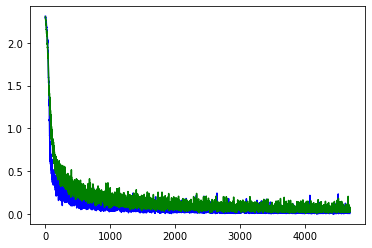

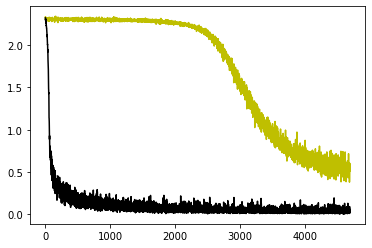

In [0]:
plt.gcf().clear()
plt.plot(ReLU_train_losses, 'b-')
plt.plot(tanh_train_losses, 'g-')
plt.show()
plt.plot(sigmoid_train_losses, 'y-')
plt.plot(leaky_relu_train_losses, 'k-')
plt.show()

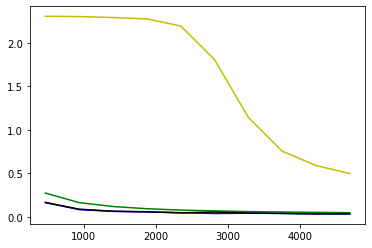

In [0]:
plt.gcf().clear()
plt.plot(ReLU_valid_x, ReLU_valid_losses, 'b-')
plt.plot(tanh_valid_x, tanh_valid_losses, 'g-')
plt.plot(sigmoid_valid_x, sigmoid_valid_losses, 'y-')
plt.plot(leaky_relu_valid_x, leaky_relu_valid_losses, 'k-')
plt.show()

Conclusion:

We can easily appreciate that the sigmoid function is the less efficient in this situation. It has a minor convergence rate and, with this number of epochs, it doesn’t reach the accuracy level of the other three functions. 

We can barely differentiate both ReLu functions from tanh, those behave similarly. Moreover, no difference can be appreciated between ReLu and leakyReLu, given that the vanishing gradient isn’t a problem in this neuronal network and leaky ReLu is designed to correct this issue.
